In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

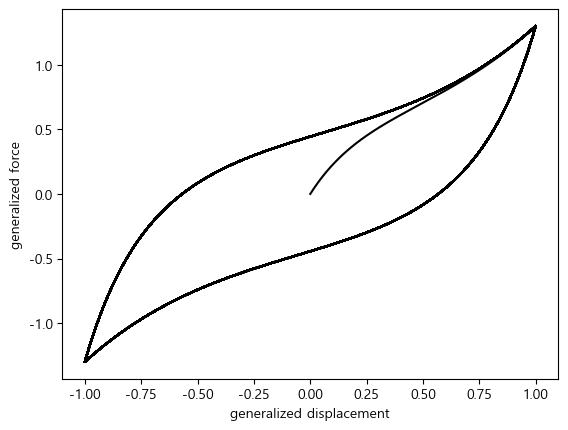

In [72]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 50 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)
uj_result = []

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

count_reuslt = []
# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    uj_result.append(uj)

    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        count_reuslt.append(i)
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [3]:
len(count_reuslt)

3000

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
sc = StandardScaler()

In [6]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [7]:
total = pd.DataFrame()

In [8]:
total['u'] = u
total['time'] = t
total['f'] = f


In [9]:
total

,u,time,f
0,0.000000e+00,0.000,0.000000
1,6.283144e-03,0.001,0.017059
2,1.256604e-02,0.002,0.033687
3,1.884844e-02,0.003,0.049898
4,2.513010e-02,0.004,0.065705
...,...,...,...
2996,-2.513010e-02,2.996,0.430554
2997,-1.884844e-02,2.997,0.433910
2998,-1.256604e-02,2.998,0.437259
2999,-6.283144e-03,2.999,0.440601


In [10]:
x = total.iloc[:,0:2]
y = total.f

In [11]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

In [12]:
x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

----
## LSTM

In [62]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(2, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1))

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [64]:
adam = optimizers.Adam(lr=0.01)

In [65]:
model.compile(loss = 'mse', optimizer = adam, metrics = 'mse')

In [66]:
history = model.fit(x_tr, y_tr, epochs = 300)

Epoch 1/300
63/63 [==============================] - 3s 2ms/step - loss: 0.1860 - mse: 0.1860
Epoch 2/300
63/63 [==============================] - 0s 2ms/step - loss: 0.1191 - mse: 0.1191
Epoch 3/300
63/63 [==============================] - 0s 2ms/step - loss: 0.1137 - mse: 0.1137
Epoch 4/300
63/63 [==============================] - 0s 3ms/step - loss: 0.1071 - mse: 0.1071
Epoch 5/300
63/63 [==============================] - 0s 3ms/step - loss: 0.1053 - mse: 0.1053
Epoch 6/300
63/63 [==============================] - 0s 3ms/step - loss: 0.1050 - mse: 0.1050
Epoch 7/300
63/63 [==============================] - 0s 3ms/step - loss: 0.1000 - mse: 0.1000
Epoch 8/300
63/63 [==============================] - 0s 3ms/step - loss: 0.1030 - mse: 0.1030
Epoch 9/300
63/63 [==============================] - 0s 3ms/step - loss: 0.0939 - mse: 0.0939
Epoch 10/300
63/63 [==============================] - 0s 3ms/step - loss: 0.0700 - mse: 0.0700
Epoch 11/300
63/63 [==============================] - 0s 3m

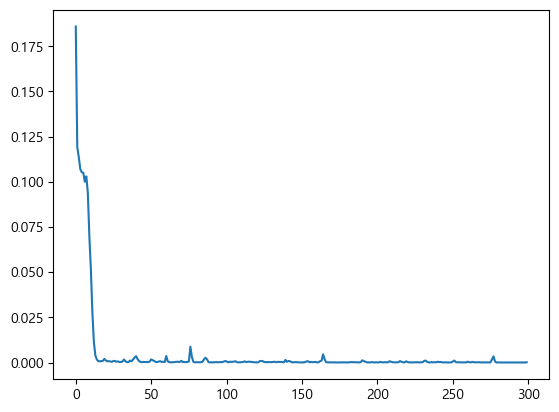

In [67]:
plt.plot(history.history['loss'])

In [68]:
pred = model.predict(x_te)

32/32 [==============================] - 1s 1ms/step


In [69]:
pred = pred.reshape(-1,1)

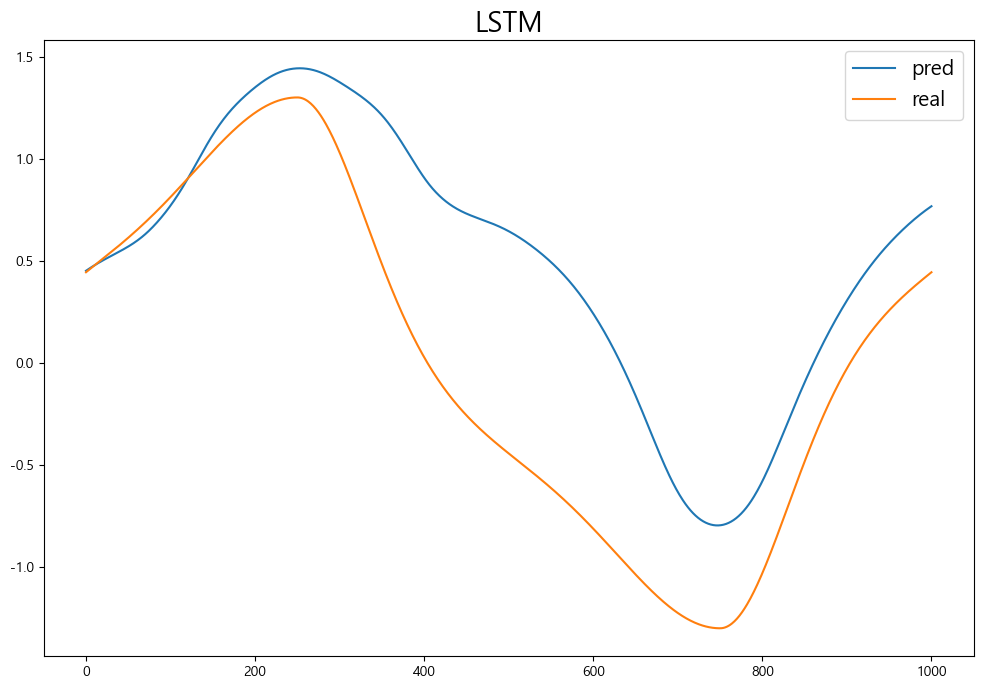

In [70]:
plt.figure(figsize=(12,8))
plt.plot(pred, label = 'pred')
plt.plot(y_te, label = 'real')
plt.title('LSTM', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

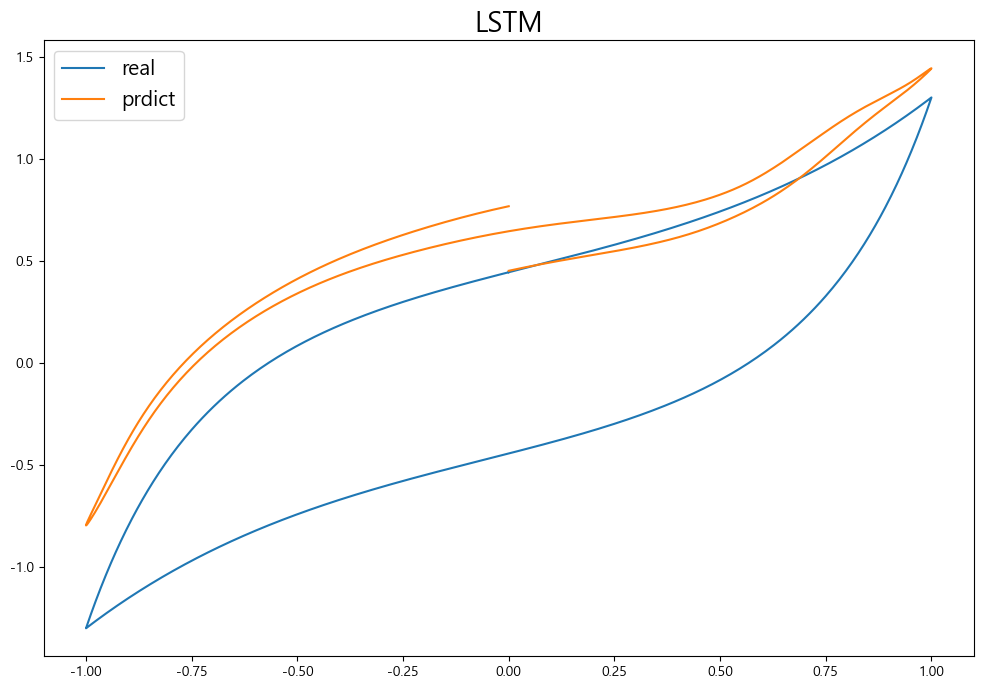

In [71]:
plt.figure(figsize=(12,8))
plt.title('LSTM', fontsize = 20)
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred, label = 'prdict')
plt.legend(fontsize  = 15)
plt.show()

----
## DNN

In [23]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(32, input_shape=(2,)))
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = adam)

In [24]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,689
Trainable params: 14,689
Non-trainable params: 0
_________________________________________________________________


In [25]:
dnn = model_2.fit(x_tr, y_tr, epochs=300)

Epoch 1/300
63/63 [==============================] - 0s 1ms/step - loss: 0.3407
Epoch 2/300
63/63 [==============================] - 0s 946us/step - loss: 0.1388
Epoch 3/300
63/63 [==============================] - 0s 954us/step - loss: 0.1294
Epoch 4/300
63/63 [==============================] - 0s 961us/step - loss: 0.1315
Epoch 5/300
63/63 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 6/300
63/63 [==============================] - 0s 979us/step - loss: 0.1197
Epoch 7/300
63/63 [==============================] - 0s 986us/step - loss: 0.1296
Epoch 8/300
63/63 [==============================] - 0s 962us/step - loss: 0.1183
Epoch 9/300
63/63 [==============================] - 0s 1ms/step - loss: 0.1059
Epoch 10/300
63/63 [==============================] - 0s 1ms/step - loss: 0.1056
Epoch 11/300
63/63 [==============================] - 0s 1ms/step - loss: 0.1018
Epoch 12/300
63/63 [==============================] - 0s 1ms/step - loss: 0.0814
Epoch 13/300
63/63 [=====

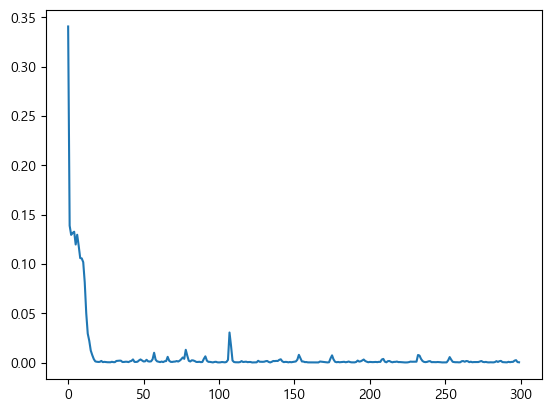

In [26]:
plt.plot(dnn.history['loss'])

In [27]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 793us/step


In [28]:
pred_2 = pred_2.reshape(-1,1)

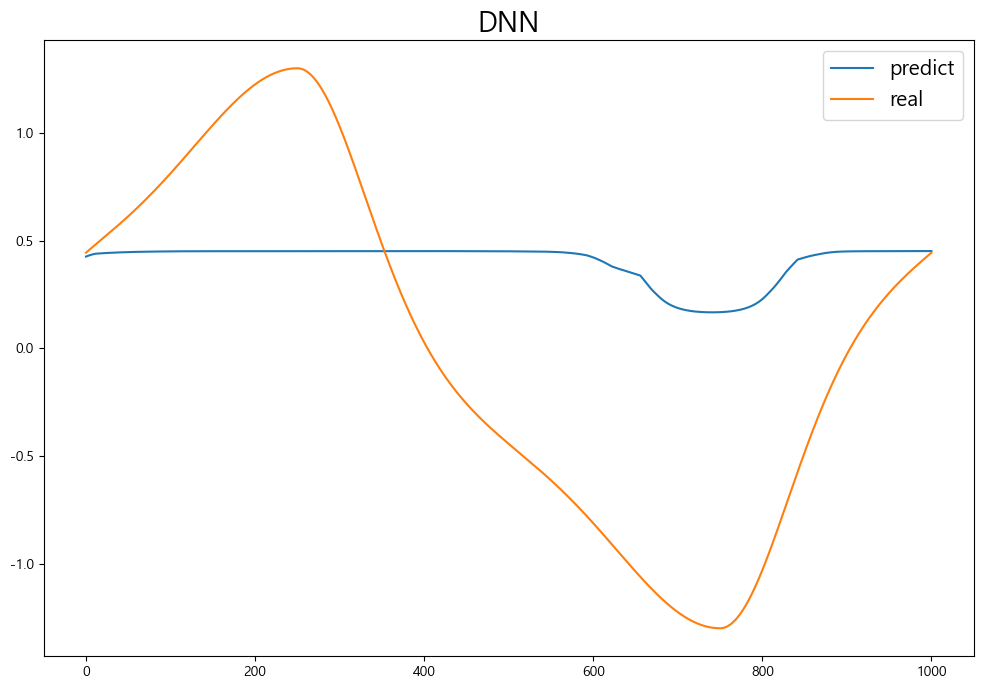

In [29]:
plt.figure(figsize=(12,8))
plt.title('DNN', fontsize = 20)
plt.plot(pred_2, label = 'predict')
plt.plot(y_te, label = 'real')
plt.legend(fontsize  = 15)
plt.show()

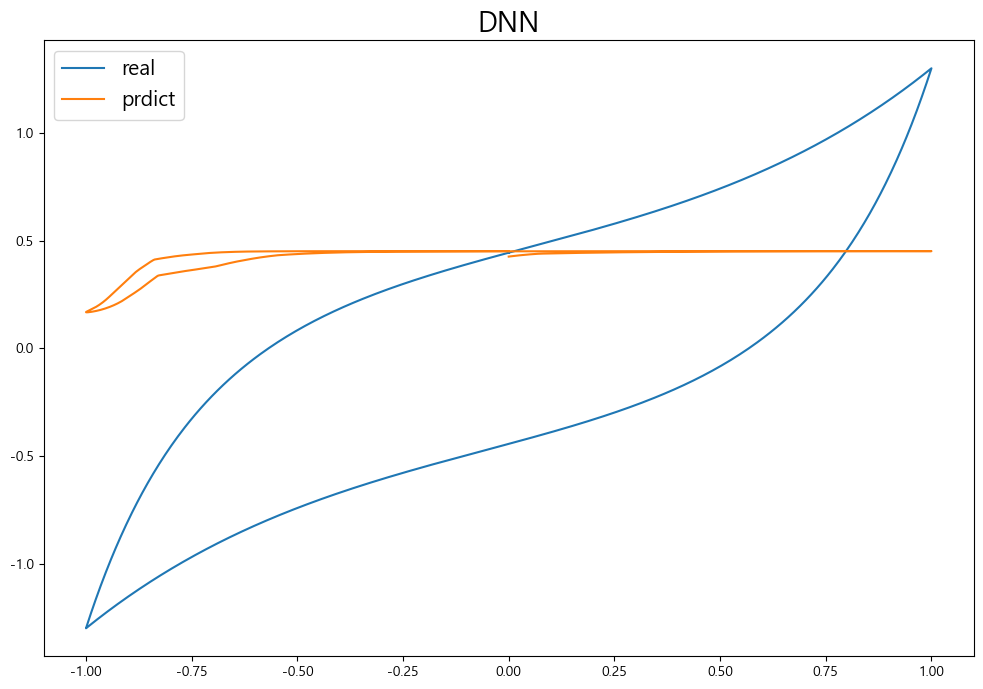

In [30]:
plt.figure(figsize=(12,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred_2, label = 'prdict')
plt.title('DNN', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

---
## PINN

In [31]:
x0, y0 = 0, 0
w = 0.5
mu = 0.1

In [32]:
from scipy.integrate import odeint
from math import *
from tqdm import tqdm

In [33]:
def xt(x, t):
    return -2*beta*x[1] + np.exp(beta*x[1]) - np.exp(-beta*x[1]) + kb*x[1] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(x[1]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [34]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=512, activation=tf.nn.tanh, dtype = tf.float32)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh, dtype = tf.float32)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [35]:
model_pinn = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

ephoch = 300

import sympy as sp

f = -2*beta*u + sp.exp(beta*u) - sp.exp(-beta*u) + kb*u - sp.sign(v)*((ka-kb)/alfa)*(sp.exp(-alfa*(sp.sign(v)*(u-uj)+2*u0))-sp.exp(-2*alfa*u0)) + sp.sign(v)*f0


In [36]:
@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj):
    with tf.GradientTape() as tape:
        tape.watch(u)  
        f = -2*beta*u + tf.exp(beta*u) - tf.exp(-beta*u) + kb*u - tf.sign(v)*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v)*(u-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v)*f0

    df_du = tape.gradient(f, u)
    df_du = tf.cast(df_du, dtype=tf.float32)
    
    return df_du

In [37]:
x_tr = tf.cast(x_tr, dtype=tf.float32)
y_tr = tf.cast(y_tr, dtype=tf.float32)

In [38]:
ka = tf.cast(5.0, tf.float32)
kb = tf.cast(0.5, tf.float32)
alfa = tf.cast(5.0, tf.float32)
beta = tf.cast(1.0, tf.float32)

u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))

In [39]:
uj = tf.cast(uj, tf.float32)

In [40]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    u, v = tf.split(x_tr, 2, axis=-1)  
    
    df_du = compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj)
    df_du = tf.expand_dims(df_du, axis=-1)
    physics_loss = tf.reduce_mean(tf.square(y_pred - df_du))

    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss

In [41]:
#batch_size = 32 
epochs = 500

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(x_tr, y_tr):
    with tf.GradientTape() as tape:
        y_pred = model_pinn(x_tr, training=True)  
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn.trainable_variables))
    return loss_value

# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))

#     for start in range(0, len(x_tr), batch_size):
#         end = start + batch_size
#         x_batch = x_tr[start:end]
#         y_batch = y_tr[start:end]
#         loss_value = train_step(x_batch, y_batch)

#         print('Training loss at step %s: %s' % (start, float(loss_value)))

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = model_pinn(x_tr, training=True)  
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn.trainable_variables))

In [42]:
y_pred_pinn = model_pinn.predict(x_te)

32/32 [==============================] - 0s 729us/step


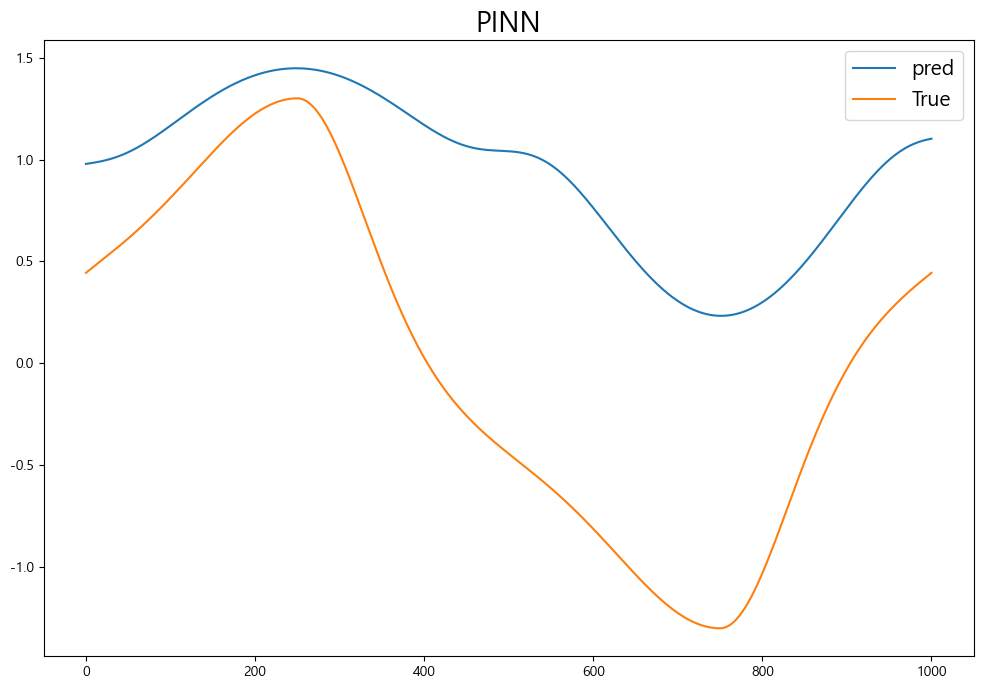

In [43]:
plt.figure(figsize=(12,8))
plt.title('PINN', fontsize = 20)
plt.plot(y_pred_pinn[:,0], label = 'pred')
plt.plot(y_te, label = 'True')
plt.legend(fontsize = 15)
plt.show()

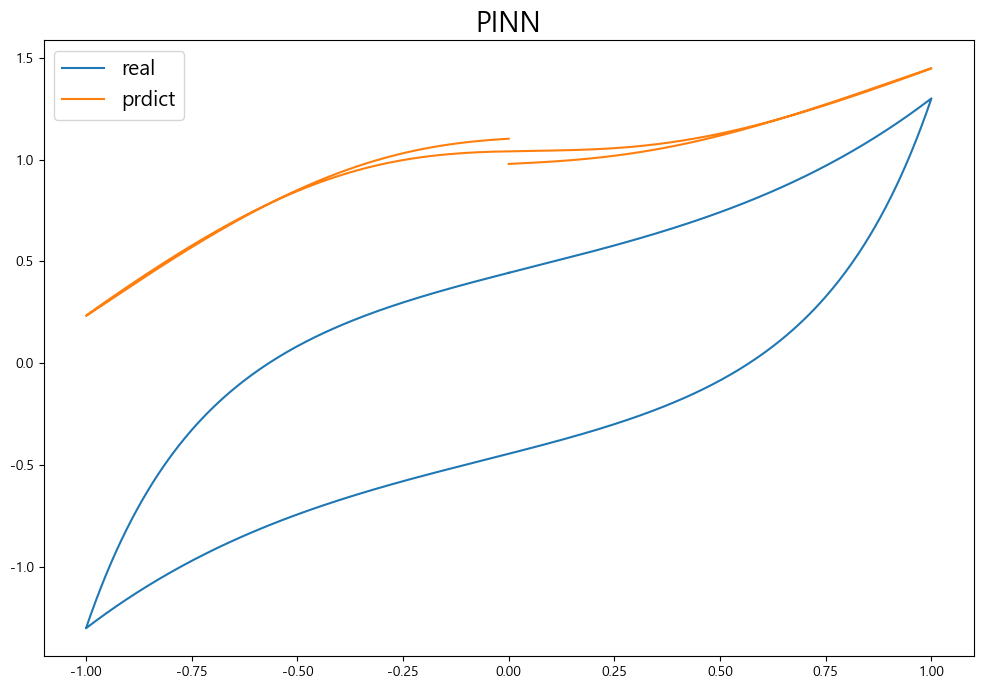

In [44]:
plt.figure(figsize=(12,8))
plt.title('PINN', fontsize = 20)
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], y_pred_pinn[:,0], label = 'prdict')
plt.legend(fontsize = 15)
plt.show()

@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0):
    with tf.GradientTape() as tape:
        tape.watch(u)
        uj_value = u + 2*u0*tf.sign(v) + tf.sign(v)*(1/alfa)*tf.math.log(tf.abs(tf.sign(v)*(alfa/(ka-kb))*(-2*beta*u+tf.exp(beta*u)-tf.exp(-beta*u)+kb*u+tf.sign(v)*((ka-kb)/alfa)*tf.exp(-2*alfa*u0)+tf.sign(v)*f0-f)))
        uj.assign(uj_value)
        f.assign(-2*beta*u + tf.exp(beta*u) - tf.exp(-beta*u) + kb*u - tf.sign(v)*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v)*(u-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v)*f0)

    # Compute the gradient df/du
    df_du = tape.gradient(f, u)

    return df_du

In [45]:
ka = tf.constant(5.0, dtype=tf.float32)
kb = tf.constant(0.5, dtype=tf.float32)
alfa = tf.constant(5.0, dtype=tf.float32)
beta = tf.constant(1.0, dtype=tf.float32)

# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * tf.math.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - tf.exp(-2 * alfa * u0))

# Initialize the generalized force vector
f = tf.Variable(tf.zeros(n), dtype=tf.float32)

# u and v are defined as per your previous code
u = tf.Variable(u, dtype=tf.float32)
v = tf.Variable(v, dtype=tf.float32)
uj = tf.Variable(uj_result[0], dtype=tf.float32)



In [46]:
@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj):
    with tf.GradientTape() as tape:
        tape.watch(u)
        i = 1
        uj = u[i-1] + 2*u0*tf.sign(v[i]) + tf.sign(v[i])*(1/alfa)*tf.math.log(tf.abs(tf.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+tf.exp(beta*u[i-1])-tf.exp(-beta*u[i-1])+kb*u[i-1]+tf.sign(v[i])*((ka-kb)/alfa)*tf.exp(-2*alfa*u0)+tf.sign(v[i])*f0-f[i-1])))
        f[i].assign(-2*beta*u[i] + tf.exp(beta*u[i]) - tf.exp(-beta*u[i]) + kb*u[i] - tf.sign(v[i])*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v[i])*(u[i]-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v[i])*f0)

    df_du = tape.gradient(f[i], u[i])

    return df_du


class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh, dtype = tf.float32)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype=tf.float32)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

epochs = 500

ka = tf.constant(5.0, dtype=tf.float32)
kb = tf.constant(0.5, dtype=tf.float32)
alfa = tf.constant(5.0, dtype=tf.float32)
beta = tf.constant(1.0, dtype=tf.float32)

u0 = tf.cast(-(1 / (2 * alfa)) * tf.math.log(10 ** -20 / (ka - kb)), tf.float32)
f0 = tf.cast(((ka - kb) / (2 * alfa)) * (1 - tf.exp(-2 * alfa * u0)), tf.float32)

u = tf.cast(u, dtype=tf.float32)
v = tf.cast(v, dtype=tf.float32)
# uj = tf.cast(tf.zeros_like(u), dtype=tf.float32)
# f = tf.cast(tf.zeros_like(u), dtype=tf.float32)

uj_initial_value = np.array([0.0])  # 초기값 설정
f_initial_value = np.zeros_like(uj_initial_value)  # 초기값 설정

uj = tf.Variable(uj_initial_value, dtype=tf.float32)
f = tf.Variable(f_initial_value, dtype=tf.float32)


@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f):
    with tf.GradientTape() as tape:
        tape.watch(u)
        i = 1
        uj_value = u[i-1] + 2*u0*tf.sign(v[i]) + tf.sign(v[i])*(1/alfa)*tf.math.log(tf.abs(tf.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+tf.exp(beta*u[i-1])-tf.exp(-beta*u[i-1])+kb*u[i-1]+tf.sign(v[i])*((ka-kb)/alfa)*tf.exp(-2*alfa*u0)+tf.sign(v[i])*f0-f[i-1])))
        uj.assign(uj_value)
        f[i].assign(-2*beta*u[i] + tf.exp(beta*u[i]) - tf.exp(-beta*u[i]) + kb*u[i] - tf.sign(v[i])*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v[i])*(u[i]-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v[i])*f0)

    df_du = tape.gradient(f[i], u[i])

    return df_du


# @tf.function
# def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f):
#     i = 0
#     with tf.GradientTape() as tape:
#         tape.watch(u)
#         uj_value = u[i] + 2 * u0 * tf.sign(v[i]) + tf.sign(v[i]) * (1 / alfa) * tf.math.log(
#             tf.abs(
#                 tf.sign(v[i])
#                 * (alfa / (ka - kb))
#                 * (
#                     -2 * beta * u[i]
#                     + tf.exp(beta * u[i])
#                     - tf.exp(-beta * u[i])
#                     + kb * u[i]
#                     + tf.sign(v[i])
#                     * ((ka - kb) / alfa)
#                     * tf.exp(-2 * alfa * u0)
#                     + tf.sign(v[i]) * f0
#                     - f[0]
#                 )
#             )
#         )
#         uj.assign(uj_value)
#         f[0].assign(
#             -2 * beta * u[i]
#             + tf.exp(beta * u[i])
#             - tf.exp(-beta * u[i])
#             + kb * u[i]
#             - tf.sign(v[i]) * ((ka - kb) / alfa) * (tf.exp(-alfa * (tf.sign(v[i]) * (u[i] - uj) + 2 * u0)) - tf.exp(-2 * alfa * u0))
#             + tf.sign(v[i]) * f0
#         )
#     df_du = tape.gradient(f[0], u)
#     return df_du



def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    u, v = tf.split(x_tr, 2, axis=-1)  
    
    df_du = compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f)
    df_du = tf.expand_dims(df_du, axis=-1)

    physics_loss = tf.reduce_mean(tf.square(y_pred - df_du))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss

def train_step(x_tr, y_tr):
    with tf.GradientTape() as tape:
        y_pred = model(x_tr, training=True)  
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

for epoch in range(epochs):
    loss_value = train_step(x_tr, y_tr)
    if epoch % 50 == 0:
        print('Training loss at epoch %d: %s' % (epoch, float(loss_value)))


In [47]:
@tf.function
def compute_boucwen_dynamics(u, z, A, B, G, n):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)  
        tape.watch(z)
        Z_dot = A*(u - B*z - G*(abs(z)**n)*tf.sign(z))

    dZ_dot_du = tape.gradient(Z_dot, u)
    dZ_dot_dz = tape.gradient(Z_dot, z)
    
    return dZ_dot_du, dZ_dot_dz

def boucwen_loss(y_true, y_pred, u, z, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    dZ_dot_du, dZ_dot_dz = compute_boucwen_dynamics(u, z, A, B, G, n)
    
    physics_loss = tf.reduce_mean(tf.square(y_pred - dZ_dot_dz))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss


In [48]:
tf.keras.backend.clear_session()

In [49]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh, dtype = tf.float32)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype = tf.float32)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [50]:
@tf.function
def compute_boucwen_dynamics(u, z, A, B, G, n):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)  
        tape.watch(z)
        Z_dot = A*(u - B*z - G*(abs(z)**n)*tf.sign(z))

    dZ_dot_du = tape.gradient(Z_dot, u)
    dZ_dot_dz = tape.gradient(Z_dot, z)
    
    return dZ_dot_du, dZ_dot_dz

In [51]:
def boucwen_loss(y_true, y_pred, u, z, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    dZ_dot_du, dZ_dot_dz = compute_boucwen_dynamics(u, z, A, B, G, n)
    
    physics_loss = tf.reduce_mean(tf.square(y_pred - dZ_dot_dz))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss

In [52]:
model_pinn_boucwen = PINN_BoucWen(1)

In [53]:
model_pinn_boucwen(x_tr, training=True)

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[0.        ],
       [0.00197645],
       [0.00395283],
       ...,
       [0.42136303],
       [0.42318848],
       [0.42501318]], dtype=float32)>

In [54]:
def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape() as tape:
        z = model_pinn_boucwen(x_tr, training=True)  # Move this line inside the tape context
        y_pred = z  
        loss_value = boucwen_loss(y_tr, y_pred, u, z, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value

In [55]:
epochs = 500
A = 1  # Set your A value
B = 1  # Set your B value
G = 1  # Set your G value
n = 1  # Set your n value


optimizer =  tf.keras.optimizers.Adam(learning_rate=0.01)

for epoch in range(epochs):
    loss_value = train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print('Training loss at epoch %s: %s' % (epoch, float(loss_value)))


Training loss at epoch 0: 15995745.0
Training loss at epoch 1: nan
Training loss at epoch 2: nan
Training loss at epoch 3: nan
Training loss at epoch 4: nan
Training loss at epoch 5: nan
Training loss at epoch 6: nan
Training loss at epoch 7: nan
Training loss at epoch 8: nan
Training loss at epoch 9: nan
Training loss at epoch 10: nan
Training loss at epoch 11: nan
Training loss at epoch 12: nan
Training loss at epoch 13: nan
Training loss at epoch 14: nan
Training loss at epoch 15: nan
Training loss at epoch 16: nan
Training loss at epoch 17: nan
Training loss at epoch 18: nan
Training loss at epoch 19: nan
Training loss at epoch 20: nan
Training loss at epoch 21: nan
Training loss at epoch 22: nan
Training loss at epoch 23: nan
Training loss at epoch 24: nan
Training loss at epoch 25: nan
Training loss at epoch 26: nan
Training loss at epoch 27: nan
Training loss at epoch 28: nan
Training loss at epoch 29: nan
Training loss at epoch 30: nan
Training loss at epoch 31: nan
Training lo

In [56]:
train_step_boucwen(x_tr, y_tr, A, B, G, n)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [57]:
z = model_pinn_boucwen(x_tr)

In [58]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(u)  
    tape.watch(z)
    term1 = A*u
    term2 = B*z
    term3 = G*(abs(z)**n)*tf.sign(z)
    Z_dot = term1 - term2 - term3

d_term1_du = tape.gradient(term1, u)
d_term2_dz = tape.gradient(term2, z)
d_term3_dz = tape.gradient(term3, z)

print(d_term1_du)
print(d_term2_dz)
print(d_term3_dz)


tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(3001,), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]], shape=(2000, 1), dtype=float32)
tf.Tensor(
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]], shape=(2000, 1), dtype=float32)


In [59]:
print(type(u))
print(type(z))


<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [60]:
pred_bouc = model_pinn_boucwen.predict(x_te)

32/32 [==============================] - 0s 785us/step


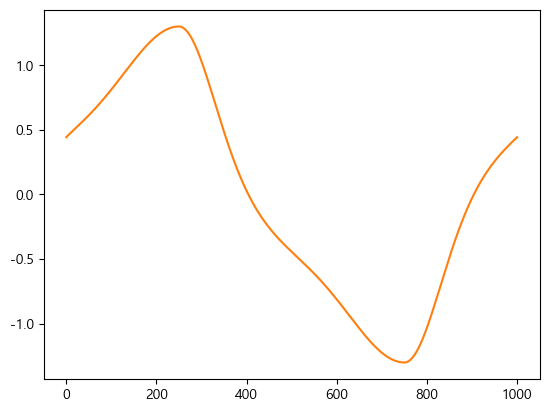

In [61]:
plt.plot(pred_bouc)
plt.plot(y_te)